## Convolutional Neural Networks in Python

In this example, we’ll learn how to implement Convolutional Neural Networks (CNNs) in Python with Keras, and how to overcome overfitting with dropout.

### The Fashion-MNIST Data Set

Before we go ahead and load in the data, it's good to take a look at what we'll exactly be working with! The Fashion-MNIST dataset is a dataset of Zalando's article images, with 28x28 grayscale images of 70,000 fashion products from 10 categories, and 7,000 images per category. The training set has 60,000 images, and the test set has 10,000 images.

We can load it with the help of specific TensorFlow and Keras modules.

### Load the Data

Keras comes with a library called datasets, which we can use to load datasets. The train and test images along with the labels are loaded and stored in variables train_X, train_Y, test_X, test_Y, respectively.

In [37]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

### Analyze the Data

Let's now analyze how images in the dataset look like. Even though we know the dimension of the images by now, it's still worth the effort to analyze it programmatically: we might have to rescale the image pixels and resize the images

In [38]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


From the above output, we can see that the training data has a shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimension. Similarly, the test data has a shape of 10000 x 28 x 28 since there are 10,000 testing samples.

In [39]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


There's also a total of ten output classes that range from 0 to 9.

Also, let's take a look at the images in our dataset:

Text(0.5, 1.0, 'Ground Truth : 9')

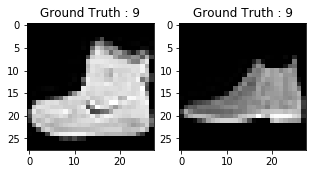

In [40]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

The output of above two plots looks like an ankle boot, and this class is assigned a class label of 9. Similarly, other fashion products will have different labels, but similar products will have same labels. This means that all the 7,000 ankle boot images will have a class label of 9.

### Data Preprocessing

As we could see in the above plot, the images are grayscale images have pixel values that range from 0 to 255. Also, these images have a dimension of 28 x 28. As a result, we'll need to preprocess the data before we feed it into the model. 

•As a first step, convert each 28 x 28 image of the train and test set into a matrix of size 28 x 28 x 1 which is fed into the network.

In [41]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

• The data right now is in an int8 format, so before we feed it into the network we need to convert its type to float32, and we also have to rescale the pixel values in range 0 - 1 inclusive. So let's do that:

In [42]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

•Now we need to convert the class labels into a one-hot encoding vector.

In one-hot encoding, we convert the categorical data into a vector of numbers. The reason why we convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. We generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.

For our problem statement, the one hot encoding will be a row vector, and for each image, it will have a dimension of 1 x 10. The important thing to note here is that the vector consists of all zeros except for the class that it represents, and for that, it is 1. For example, the ankle boot image that we plotted above has a label of 9, so for all the ankle boot images, the one hot encoding vector would be [0 0 0 0 0 0 0 0 1 0]. 

So let's convert the training and testing labels into one-hot encoding vectors:

In [52]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


• This last step is a crucial one. In machine learning or any data specific task, we should partition the data correctly. For the model to generalize well, we split the training data into two parts, one designed for training and another one for validation. In this case, we will train the model on 80\% of the training data and validate it on 20\% of the remaining training data. This will also help to reduce overfitting since we will be validating the model on the data it would not have seen in training phase, which will help in boosting the test performance.

In [44]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

For one last time let's check the shape of training and validation set.

In [45]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

### The Network

The images are of size 28 x 28. We convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, and feed this as an input to the network. 

We'll use three convolutional layers:   
•The first layer will have 32-3 x 3 filters,  
•The second layer will have 64-3 x 3 filters and  
•The third layer will have 128-3 x 3 filters.

In addition, there are three max-pooling layers each of size 2 x 2.
<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/fashion-mnist-architecture_htbpsz.png" alt="Drawing" style="height: 200px;"/>

                                        Architecture of the Model
                                        
### Model the Data

First, let's import all the necessary modules required to train the model.

In [46]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

We will use a batch size of 64 using a higher batch size of 128 or 256 is also preferable it all depends on the memory. It contributes massively to determining the learning parameters and affects the prediction accuracy. We will train the network for 20 epochs.

In [47]:
batch_size = 64
epochs = 20
num_classes = 10

### Neural Network Architecture

In Keras, we can just stack up layers by adding the desired layer one by one. That's exactly what we'll do here: we'll first add a first convolutional layer with Conv2D(). Note that we use this function because we're working with images! Next, we add the Leaky ReLU activation function which helps the network learn non-linear decision boundaries. Since we have ten different classes, we'll need a non-linear decision boundary that could separate these ten classes which are not linearly separable. 

More specifically, we add Leaky ReLUs because they attempt to fix the problem of dying Rectified Linear Units (ReLUs). The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope. 

Next, we'll add the max-pooling layer with MaxPooling2D() and so on. The last layer is a Dense layer that has a softmax activation function with 10 units, which is needed for this multi-class classification problem.

In [48]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

### Compile the Model

After the model is created, we compile it using the Adam optimizer, one of the most popular optimization algorithms. Additionally, we specify the loss type which is categorical cross entropy which is used for multi-class classification, we can also use binary cross-entropy as the loss function. Lastly, we specify the metrics as accuracy which we want to analyze while the model is training.

In [49]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Let's visualize the layers that we created in the above step by using the summary function. This will show some parameters (weights and biases) in each layer and also the total parameters in your model.

In [50]:
fashion_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)        

### Train the Model

It's finally time to train the model with Keras' fit() function. The model trains for 20 epochs. The fit() function will return a history object; By storing the result of this function in fashion_train, we can use it later to plot the accuracy and loss function plots between training and validation which will help us to analyze our model's performance visually.

In [51]:
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 74s 2ms/step - loss: 0.4643 - accuracy: 0.8312 - val_loss: 0.3655 - val_accuracy: 0.8684
Epoch 2/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.2920 - accuracy: 0.8932 - val_loss: 0.2675 - val_accuracy: 0.9024
Epoch 3/20
48000/48000 [==============================] - 72s 2ms/step - loss: 0.2415 - accuracy: 0.9113 - val_loss: 0.2441 - val_accuracy: 0.9087
Epoch 4/20
48000/48000 [==============================] - 76s 2ms/step - loss: 0.2081 - accuracy: 0.9236 - val_loss: 0.2412 - val_accuracy: 0.9105
Epoch 5/20
48000/48000 [==============================] - 142s 3ms/step - loss: 0.1825 - accuracy: 0.9330 - val_loss: 0.2283 - val_accuracy: 0.9193
Epoch 6/20
48000/48000 [==============================] - 145s 3ms/step - loss: 0.1576 - accuracy: 0.9417 - val_loss: 0.2414 - val_accuracy: 0.9137
Epoch 7/20
48000/48000 [==============================] - 146s 3ms

Finally! We trained the model on fashion-MNIST for 20 epochs, and by observing the training accuracy and loss, we can say that the model did a good job since after 20 epochs the training accuracy is 99% and the training loss is quite low.

However, it looks like the model is overfitting, as the validation loss is 0.4480 and the validation accuracy is 92%. Overfitting gives an intuition that the network has memorized the training data very well but is not guaranteed to work on unseen data, and that is why there is a difference in the training and validation accuracy. 

We probably need to handle this. In next sections, we'll learn how we can make our model perform much better by adding a Dropout layer into the network and keeping all the other layers unchanged. 

But first, let's evaluate the performance of our model on the test set before we come on to a conclusion.

### Model Evaluation on the Test Set

In [19]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [20]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.468688831891492
Test accuracy: 0.916700005531311


The test accuracy looks impressive.

However, we saw that the model looked like it was overfitting.

Let's put our model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

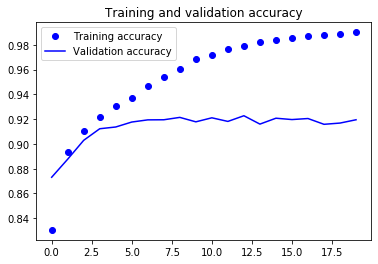

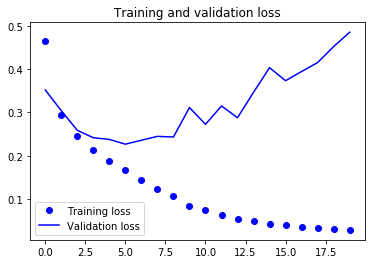

In [21]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, we can see that the validation accuracy almost became stagnant after 4-5 epochs and rarely increased at certain epochs. In the beginning, the validation accuracy was linearly increasing with loss, but then it did not increase much.

The validation loss shows that this is the sign of overfitting, similar to validation accuracy it linearly decreased but after 4-5 epochs, it started to increase. This means that the model tried to memorize the data and succeeded.

With this in mind, it's time to introduce some dropout into our model and see if it helps in reducing overfitting.



### Adding Dropout into the Network

We can add a dropout layer to overcome the problem of overfitting to some extent. Dropout randomly turns off a fraction of neurons during the training process, reducing the dependency on the training set by some amount. How many fractions of neurons we want to turn off is decided by a hyperparameter, which can be tuned accordingly. This way, turning off some neurons will not allow the network to memorize the training data since not all the neurons will be active at the same time and the inactive neurons will not be able to learn anything.

So let's create, compile and train the network again but this time with dropout. And run it for 20 epochs with a batch size of 64.

In [22]:
batch_size = 64
epochs = 20
num_classes = 10

In [23]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))

In [24]:
fashion_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)         

In [25]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [26]:
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 91s 2ms/step - loss: 0.5837 - accuracy: 0.7826 - val_loss: 0.3712 - val_accuracy: 0.8625
Epoch 2/20
48000/48000 [==============================] - 100s 2ms/step - loss: 0.3748 - accuracy: 0.8633 - val_loss: 0.3144 - val_accuracy: 0.8857
Epoch 3/20
48000/48000 [==============================] - 95s 2ms/step - loss: 0.3340 - accuracy: 0.8762 - val_loss: 0.2845 - val_accuracy: 0.8953
Epoch 4/20
48000/48000 [==============================] - 95s 2ms/step - loss: 0.3000 - accuracy: 0.8880 - val_loss: 0.2692 - val_accuracy: 0.9014
Epoch 5/20
48000/48000 [==============================] - 98s 2ms/step - loss: 0.2872 - accuracy: 0.8926 - val_loss: 0.2581 - val_accuracy: 0.9044
Epoch 6/20
48000/48000 [==============================] - 91s 2ms/step - loss: 0.2739 - accuracy: 0.8981 - val_loss: 0.2443 - val_accuracy: 0.9071
Epoch 7/20
48000/48000 [==============================] - 89s 2ms/s

### Model Evaluation on the Test Set

Finally, let's also evaluate our new model and see how it performs!

In [27]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)

10000/10000 [==============================] - 5s 475us/step


In [28]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.2214432045698166
Test accuracy: 0.9218000173568726


Looks like adding Dropout in our model worked, even though the test accuracy did not improve significantly but the test loss decreased compared to the previous results.

Now, let's plot the accuracy and loss plots between training and validation data for the one last time.

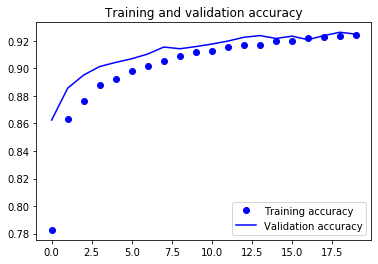

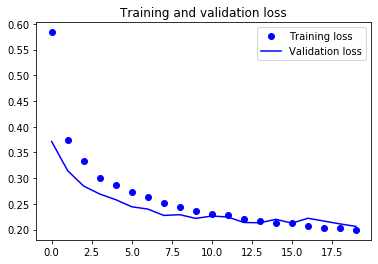

In [29]:
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finally, we can see that the validation loss and validation accuracy both are in sync with the training loss and training accuracy. Even though the validation loss and accuracy line are not linear, but it shows that our model is not overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training and validation accuracy.

Therefore, we can say that our model's generalization capability became much better since the loss on both test set and validation set was only slightly more compared to the training loss.

### Predict Labels

In [30]:
predicted_classes = fashion_model.predict(test_X)

Since the predictions we get are floating point values, it will not be feasible to compare the predicted labels with true test labels. So, we will round off the output which will convert the float values into an integer. Further, you will use np.argmax() to select the index number which has a higher value in a row. 

For example, let's assume a prediction for one test image to be 0 1 0 0 0 0 0 0 0 0, the output for this should be a class label 1.

In [31]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [32]:
predicted_classes.shape, test_Y.shape

((10000,), (10000,))

Found 9196 correct labels


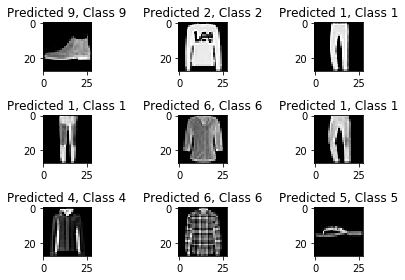

In [33]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 804 incorrect labels


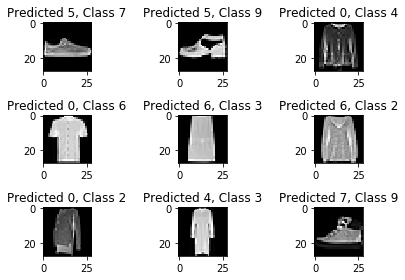

In [34]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

By looking at a few images, we cannot be sure as to why our model is not able to classify the above images correctly, but it seems like a variety of the similar patterns present on multiple classes affect the performance of the classifier although CNN is a robust architecture. For example, images 5 and 6 both belong to different classes but look kind of similar maybe a jacket or perhaps a long sleeve shirt.

### Classification Report

Classification report will help us in identifying the misclassified classes in more detail. We will be able to observe for which class the model performed bad out of the given ten classes.

In [35]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.80      0.90      0.85      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.89      0.87      0.88      1000
     Class 3       0.93      0.92      0.93      1000
     Class 4       0.86      0.90      0.88      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.83      0.71      0.77      1000
     Class 7       0.94      0.99      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



WE can see that the classifier is underperforming for class 6 regarding both precision and recall. For class 0 and class 2, the classifier is lacking precision. Also, for class 4, the classifier is slightly lacking both precision and recall.